In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import transformations as tf
import matplotlib.pyplot as plt
import pcl
import os
import os.path as osp

In [58]:
BASE_PATH = './data/tree2/test'
# keyframes = pd.read_csv(osp.join(BASE_PATH, 'keyframes_with_id.txt'), sep=' ')
objects = pd.read_csv(osp.join(BASE_PATH,'objects.txt'), sep=' ')
# Loaded as XYZ pointclouds
map_cloud = pcl.load(osp.join(BASE_PATH, 'map.pcd'))
# object clouds
obj_clouds = {}
for i in objects['#id']:
    obj_clouds[i] = pcl.load(osp.join(BASE_PATH, 'object_pointclouds', '{}.pcd'.format(i)))

In [55]:
def add_tf_mat_to_df(df, use_shift_centroid=False):
    try:
        df.drop(columns=['T'])
    except KeyError:
        pass
    
    def _get_tf_mat_from_row(drow):
        q = np.array(drow[['qw', 'qx', 'qy', 'qz']])
        t = None
        if use_shift_centroid:
            t = np.array(drow[['x_cloud', 'y_cloud', 'z_cloud']]).reshape(3)  
        else:
            t = np.array(drow[['x', 'y', 'z']]).reshape(3)
        T = tf.quaternion_matrix(q)
        T[:3, 3] = t
        return T

    df['T'] = df.apply(_get_tf_mat_from_row, axis=1)

def transform_cloud(T, points):
    points_homo = np.ones((points.shape[0], 4))
    points_homo[:,:3] = points
    points_homo = np.transpose(points_homo)
    outs = np.matmul(T, points_homo)
    return np.transpose(outs)[:, :3]

# Transform all points to local
def get_local_points(Two, points):
    Tow = np.linalg.inv(Two)
    points_homo = np.ones((points.shape[0], 4))
    points_homo[:,:3] = points
    points_homo = np.transpose(points_homo)
    outs = np.matmul(Tow, points_homo)
    return np.transpose(outs)[:, :3]

def add_shift_centroid_data(objects, obj_clouds):
    results = []
    results_cols = ['#id', 'x_cloud', 'y_cloud', 'z_cloud']
    for i, cloud in obj_clouds.items():
        cloud_arr = np.asarray(cloud)
        centroid = np.mean(cloud_arr, axis=0)
        # TODO -- find boundary using PCA
        results.append((i, *centroid))

    df = pd.DataFrame(results, columns=results_cols)
    return pd.merge(objects, df, on='#id')

In [59]:
USE_SHIFT_CENTROID=False
objects = add_shift_centroid_data(objects, obj_clouds)
add_tf_mat_to_df(objects, use_shift_centroid=USE_SHIFT_CENTROID)

In [62]:
USE_SHIFT_CENTROID=False

,#id,label,x,y,z,qx,qy,qz,qw,sx,sy,sz,x_cloud,y_cloud,z_cloud,T
0,0,0,2.137294,0.601331,3.877034,0.584839,-0.324283,0.396349,0.629056,0.431192,0.479107,0.087841,1.944592,0.449677,3.265885,"[[0.47549606516709875, -0.8779580353347702, 0...."
1,1,0,4.381115,0.915378,5.465585,0.601855,-0.291490,0.361005,0.649984,0.666446,0.372832,0.098058,4.190695,0.870445,5.126884,"[[0.569417798263272, -0.8201646452411815, 0.05..."


In [6]:
def get_value_by_id(df, id, col_name):
    return objects[objects['#id'] == id][col_name][0]

def get_row_by_id(df, id):
    return objects[objects['#id'] == id].iloc[0]

In [7]:
# Transform mappoints to first object (id=0) frame ref
Tw0 = objects[objects['#id'] == 0]['T'][0]
map_cloud_0 = pcl.PointCloud(get_local_points(Tw0, np.asarray(map_cloud)).astype(np.float32))

In [8]:
pcl.save(map_cloud_0, 'world.pcd')

In [9]:
def _get_cloud_in_box(cloud, size_xy, height_min, height_max, origin):
    # TODO -- fix this using numpy all
    out = cloud

    # Filter X
    out = out[ out[:, 0] >= origin[0] - size_xy[0]]
    out = out[ out[:, 0] <= origin[0] + size_xy[0]]

    # Filter Y
    out = out[ out[:, 1] >= origin[1] - size_xy[1]]
    out = out[ out[:, 1] <= origin[1] + size_xy[1]]

    # Filter Height
    out = out[ out[:, 2] >= origin[2] - height_min ]
    out = out[ out[:, 2] <= origin[2] + height_max ]

    return out

# # TODO -- fix this!
# def get_tree_cloud_in_objects(map_cloud, objects, height=5.0, height_min=0.5, size_xy=None):
#     outcloud = {}
#     map_cloud_raw = np.asarray(map_cloud)
#     if size_xy is not None:
#         assert(len(size_xy) == 2)
    
#     for i in objects['#id']:
#         s_size = [0,0]
#         obj = get_row_by_id(objects, i)
#         T_ref0 = obj['T_ref0']
#         t = T_ref0[:3, 3] # centroid
#         print(t)
#         if size_xy is None:
#             s_size[0] = obj['sx']
#             s_size[1] = obj['sy']
#         else:
#             s_size = size_xy
        
#         tmp_cloud = _get_cloud_in_box(map_cloud_raw, size_xy, height_min, height, t)

#         outcloud[i] = pcl.PointCloud(tmp_cloud.astype(np.float32))

#     return outcloud

In [14]:
# get from world
def naive_get_tree_cloud_in_objects(map_cloud, objects, height=5.0, height_min=0.5, size_xy=None):
    outcloud = {}
    map_cloud_raw = np.asarray(map_cloud)
    if size_xy is not None:
        assert(len(size_xy) == 2)
    
    for i in objects['#id']:
        s_size = [0,0]
        obj = get_row_by_id(objects, i)
        T_ref0 = obj['T']
        t = (0,0,0) # centroid
        if size_xy is None:
            s_size[0] = obj['sx']
            s_size[1] = obj['sy']
        else:
            s_size = size_xy
        map_cloud_local = get_local_points(T_ref0, map_cloud_raw)
        tmp_cloud = _get_cloud_in_box(map_cloud_local, size_xy, height_min, height, t)

        outcloud[i] = pcl.PointCloud(tmp_cloud.astype(np.float32))

    return outcloud

In [15]:
# For visualization purpose
def reconstruct_world_cloud(tree_clouds, objects, ref_id=None):
    out = []
    for i, cloud in tree_clouds.items():
        obj = get_row_by_id(objects, i)
        icloud = transform_cloud(obj['T'], np.asarray(cloud))
        out.append(icloud)
    
    outcloud = np.concatenate(out, axis=0)

    if ref_id is None:
        return pcl.PointCloud(outcloud.astype(np.float32))

    ref_obj = get_row_by_id(objects, ref_id)
    refcloud = get_local_points(ref_obj['T'], outcloud)

    return pcl.PointCloud(refcloud.astype(np.float32))

# Same as above but split for each object
def reconstruct_each_object_clouds_world(tree_clouds, objects, ref_id=None):
    out = {}
    ref_obj=None
    if ref_id is not None:
        ref_obj = get_row_by_id(objects, ref_id)
    
    for i, cloud in tree_clouds.items():
        obj = get_row_by_id(objects, i)
        icloud = transform_cloud(obj['T'], np.asarray(cloud))
        if ref_id is None:
            out[i] = pcl.PointCloud(icloud.astype(np.float32))
        else:
            refcloud = get_local_points(ref_obj['T'], icloud)
            out[i] = pcl.PointCloud(refcloud.astype(np.float32))
    return out

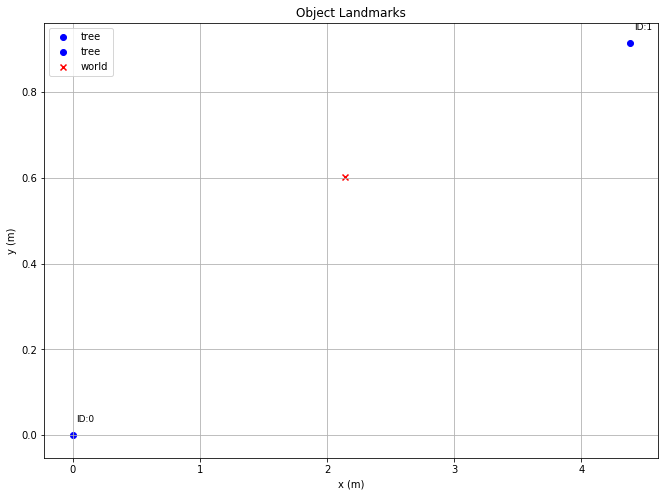

In [75]:
# Plot 2d Object in Ref ID cooridinate
REF_ID=0
plt.figure(figsize=(11,8))
plt.ylabel('y (m)')
plt.xlabel('x (m)')
plt.title('Object Landmarks')
plt.grid(True)
# Draw object center
centroids = None
if USE_SHIFT_CENTROID:
    centroids = objects[['#id','x_cloud', 'y_cloud', 'z_cloud']]
else:
    centroids = objects[['#id','x', 'y', 'z']]

T_ref = objects[objects['#id'] == REF_ID].iloc[0]['T']
# origin
origin_ref = np.matmul(T_ref, np.array([0,0,0,1]).T)[:2]

points_data = np.asarray(centroids)
centroids_ref = get_local_points(T_ref, points_data[:, 1:])
out = np.zeros((points_data.shape[0], 3)) #id, x, y
out[:, 0] = points_data[:, 0]
out[:, 1:] = points_data[:, 1:3]
for obj in out:
    if int(obj[0]) == REF_ID:
        plt.scatter(0, 0, marker='o', color='b', label='tree')
        plt.text(.03, .03, 'ID:0', fontsize=9)
    else:
        plt.scatter(obj[1], obj[2], marker='o', color='b', label='tree')
        plt.text(obj[1]+.03, obj[2]+.03, 'ID:{}'.format(int(obj[0])), fontsize=9)

# plot origin
plt.scatter(origin_ref[0], origin_ref[1], marker='x', color='r', label='world')


# plt.plot(objects['x'][IDX], objects['z'][IDX], 'ro', color='b', label='objects')

plt.legend()


In [63]:
np.asarray(objects[['x', 'y', 'z']])

array([[2.137294, 0.601331, 3.877034],
       [4.381115, 0.915378, 5.465585]])

In [21]:
# DO NOT USE map_cloud_0, use world
tree_clouds = naive_get_tree_cloud_in_objects(map_cloud, objects, size_xy=(1.5,1.5), height_min=0)
recon = reconstruct_world_cloud(tree_clouds, objects, ref_id=0)
recon_each = reconstruct_each_object_clouds_world(tree_clouds, objects, ref_id=0)
pcl.save(recon, 'recon.pcd')

In [92]:
pcl.save(tree_clouds[1], '1.pcd')

In [83]:
OBJECT_ID = 0
# Coarse SOR
obj = get_row_by_id(objects, OBJECT_ID)
fil = tree_clouds[OBJECT_ID].make_statistical_outlier_filter()
fil.set_mean_k(40)
fil.set_std_dev_mul_thresh(1.0)
step0_inliers = fil.filter()
pcl.save(step0_inliers, 'step0.pcd')

# Remove trunk
fil = step0_inliers.make_passthrough_filter()
fil.set_filter_field_name('z')
fil.set_filter_limits(obj['sz']*2, 99.0)
step1_inliers = fil.filter()
pcl.save(step1_inliers, 'step1.pcd')

# Smooth cylinder surface
fil = step1_inliers.make_moving_least_squares()
fil.set_search_radius(0.4)
fil.set_polynomial_order(2)
step2_inliers = fil.process()
pcl.save(step2_inliers, 'step2.pcd')

# Fine SOR
fil = step2_inliers.make_statistical_outlier_filter()
fil.set_mean_k(5)
fil.set_std_dev_mul_thresh(1.0)
step3_inliers = fil.filter()
pcl.save(step3_inliers, 'step3.pcd')

# SAC_cylinder extraction (not work)
# seg = step3_inliers.make_segmenter_normals()
# seg.set_optimize_coefficients(True)
# seg.set_model_type(pcl.SACMODEL_CYLINDER)
# seg.set_method_type(pcl.SAC_RANSAC)
# seg.set_max_iterations(10000)
# seg.set_normal_distance_weight(0.1)
# seg.set_distance_threshold(1) # this is quite sparse pointclouds
# seg.set_axis(0,0,1)
# indices, model = seg.segment()

In [147]:
def post_process_tree_cloud(tree, sz):
    # Coarse SOR
    fil = tree.make_statistical_outlier_filter()
    fil.set_mean_k(40)
    fil.set_std_dev_mul_thresh(1.0)
    step0_inliers = fil.filter()
    # Remove trunk
    fil = step0_inliers.make_passthrough_filter()
    fil.set_filter_field_name('z')
    fil.set_filter_limits(sz*2, 99.0)
    step1_inliers = fil.filter()
    # Smooth cylinder surface
    fil = step1_inliers.make_moving_least_squares()
    fil.set_search_radius(0.5)
    fil.set_polynomial_order(2)
    step2_inliers = fil.process()
    # Fine SOR
    fil = step2_inliers.make_statistical_outlier_filter()
    fil.set_mean_k(10)
    fil.set_std_dev_mul_thresh(0.7)
    step3_inliers = fil.filter()
    return step3_inliers

# Assume that trunk and outliers are completely eliminate
def get_approx_diameter(cloud):
    cloud_array = np.asarray(cloud)
    bound_mins = np.min(cloud_array, axis=0)
    bound_maxs = np.max(cloud_array, axis=0)
    size_x = bound_maxs[0] - bound_mins[0]
    size_y = bound_maxs[1] - bound_mins[1]
    return np.max((size_x, size_y))

def get_approx_diameter_middle_chunk(cloud, percent_cut=0.4):
    cloud_array = np.asarray(cloud)
    # find middle chunk along z
    z_min = np.min(cloud_array[:,2])
    z_max = np.max(cloud_array[:,2])
    z_size = (z_max - z_min) / 2.0
    centroid = np.mean(cloud_array, axis=0)
    z_th_upper = centroid[2] + (z_size * percent_cut)
    z_th_lower = centroid[2] - (z_size * percent_cut)
    cloud_array_inliers = cloud_array[ cloud_array[:, 2] < z_th_upper]
    cloud_array_inliers = cloud_array_inliers[ cloud_array_inliers[:, 2] > z_th_lower]

    return get_approx_diameter(cloud_array_inliers)

In [133]:
for i, cloud in tree_clouds.items():
    obj = get_row_by_id(objects, i)
    cloud = post_process_tree_cloud(cloud, obj['sz'])
    pcl.save(cloud, 'post{}.pcd'.format(i))

In [148]:
obj = get_row_by_id(objects, 0)
cloud = post_process_tree_cloud(tree_clouds[0], obj['sz'])
print(get_approx_diameter(cloud))
print(get_approx_diameter_middle_chunk(cloud))

1.0453691
0.8730954


In [146]:
pcl.save(cloud, 'temp1.pcd')
cloud_array = np.asarray(cloud)
percent_cut = 0.4
# find middle chunk along z
z_min = np.min(cloud_array[:,2])
z_max = np.max(cloud_array[:,2])
z_size = (z_max - z_min) / 2.0
centroid = np.mean(cloud_array, axis=0)
z_th_upper = centroid[2] + (z_size * percent_cut)
z_th_lower = centroid[2] - (z_size * percent_cut)
print('upper: {}, lower{}'.format(z_th_upper, z_th_lower))

cloud_array_inliers = cloud_array[ cloud_array[:, 2] < z_th_upper]
cloud_array_inliers = cloud_array_inliers[ cloud_array_inliers[:, 2] > z_th_lower]

pcl.save(pcl.PointCloud(cloud_array_inliers.astype(np.float32)), 'temp2.pcd')
bound_mins = np.min(cloud_array_inliers, axis=0)
bound_maxs = np.max(cloud_array_inliers, axis=0)
size_x = bound_maxs[0] - bound_mins[0]
size_y = bound_maxs[1] - bound_mins[1]
np.max((size_x, size_y))

upper: 0.9747825741767884, lower0.5372941613197326


0.8730954

sx:0.9983126521110535, sy:0.32175615429878235


In [117]:
2.46 / np.pi

0.783042320012125

In [34]:
dir(fil)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'process',
 'set_Compute_Normals',
 'set_Search_Method',
 'set_polynomial_fit',
 'set_polynomial_order',
 'set_search_radius']

In [129]:
objects

,#id,label,x,y,z,qx,qy,qz,qw,sx,sy,sz,T,T_ref0
0,0,0,2.137294,0.601331,3.877034,0.584839,-0.324283,0.396349,0.629056,0.431192,0.479107,0.087841,"[[0.47549606516709875, -0.8779580353347702, 0....","[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [..."
1,1,0,4.381115,0.915378,5.465585,0.601855,-0.291490,0.361005,0.649984,0.666446,0.372832,0.098058,"[[0.569417798263272, -0.8201646452411815, 0.05...","[[0.2707559225102987, -0.09788232827841803, 0...."


In [122]:
tf.transformations.inverse_matrix(objects['T_ref0'].iloc[1])[:, 3]

array([ 77.67544699,   6.5171438 , -16.95360563,   1.        ])

In [131]:
tf.transformations.translation_from_matrix(objects['T_ref0'].iloc[1])

array([-1.95713391e+01,  1.77010514e-02,  3.75587035e-01])

Cylinder extraction params
http://docs.pointclouds.org/trunk/group__sample__consensus.html